# Machine Learning Approaches for News Analysis

By: Isaac Cutajar

The scope of this workbook is to use a Random Forest (RF) model on the features extracted from the two data sets provided, police press releases and news articles.

Dataset used : `data.csv`


## RF in our context:
- Will be focusing on the classification of accident severity
- Which features should be used to train the model

## 1. Introduction to Random Forest

### 1.1 Theoretical Foundation

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Each tree is trained on a bootstrap sample of the data, and predictions are aggregated through majority voting (classification) or averaging (regression).

source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 1.2 Why Random Forest for Accident Severity Classification?

Random Forest is particularly suitable for our accident fatality classification task for several reasons:

**1. Handling Mixed Feature Types**
- Our dataset contains a mix of categorical (e.g., street_type, region, accident_time_category) and numerical features (e.g., total_injured, temperature_max, num_drivers_total)
- Random Forest naturally handles both types without requiring extensive preprocessing or encoding

**2. Robustness to Non-linear Relationships**
- Accident severity may have complex, non-linear relationships with features like driver age groups, vehicle types, and weather conditions
- RF's ensemble of decision trees can capture these intricate patterns that linear models might miss

**3. Feature Importance Analysis**
- RF provides built-in feature importance metrics, helping us understand which factors (e.g., time of day, weather, number of vehicles) most strongly influence accident severity
- This is valuable for both model interpretation and potential policy recommendations

**4. Handling Imbalanced Data**
- Accident severity classes may be imbalanced (e.g., more minor accidents than fatal ones)
- RF can be configured with class weights and performs reasonably well on imbalanced datasets

**5. Resistance to Overfitting**
- The ensemble approach with multiple trees and bootstrap sampling reduces overfitting compared to single decision trees
- This is crucial given our dataset's moderate size after filtering (post-November 2024)

**6. No Strict Assumptions**
- Unlike many statistical models, RF doesn't require assumptions about feature distributions, linearity, or independence
- This flexibility is ideal for real-world accident data which may violate such assumptions

## 2. Data Preparation and Preprocessing

### 2.1 Import libraries

In [3]:
# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning components
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import randint
from sklearn.base import clone

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

### 2.2 Load Dataset

Loading the cleaned dataset from the EDA phase and examining class distribution to understand the imbalance between fatal and non-fatal accidents.

In [4]:
df = pd.read_csv('../../data/final/data_post_eda.csv')


print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nAccident severity distribution:")
print(df['accident_severity'].value_counts())

Dataset loaded: 211 rows, 58 columns

Accident severity distribution:
accident_severity
grievious      85
serious        74
fatal          28
not injured    17
slight          7
Name: count, dtype: int64


In [5]:
# Convert boolean columns in the data set from (True/False) to numeric (1/0)
bool_columns = df.select_dtypes(include=['bool']).columns
if len(bool_columns) > 0:
    df[bool_columns] = df[bool_columns].astype(int)
    print(f"✓ Converted {len(bool_columns)} boolean columns to numeric (1/0):")
    print(f"  {list(bool_columns)}")
else:
    print("✓ No boolean columns found to convert")

✓ Converted 21 boolean columns to numeric (1/0):
  ['driver_under_18', 'driver_18_to_24', 'driver_25_to_49', 'driver_50_to_64', 'driver_65_plus', 'driver_age_unknown', 'driver_male', 'driver_female', 'driver_gender_unknown', 'vehicle_unknown', 'vehicle_pedestrian', 'vehicle_bicycle', 'vehicle_motorbike', 'vehicle_car', 'vehicle_van', 'vehicle_bus', 'is_weekend', 'is_public_holiday_mt', 'is_school_holiday_mt', 'is_school_day_mt', 'is_raining']


### 2.3 Data Type Conversions

Converting boolean columns to numeric format (0/1) for compatibility with scikit-learn models.

In [6]:
# Create binary severity classification: FATAL/NON-FATAL
# NON-FATAL: not injured, slight, grievious, serious
# FATAL: fatal
def map_severity_to_binary(severity):
    non_fatal = ['not injured', 'slight','grievious', 'serious']
    fatal = [ 'fatal']
    
    if severity in non_fatal:
        return 0  # NON-FATAL
    elif severity in fatal:
        return 1  # FATAL
    else:
        return None  # Handle unexpected values

df['is_fatal'] = df['accident_severity'].apply(map_severity_to_binary)

print("\nSeverity Distribution (Binary):")
print(df['is_fatal'].value_counts())

print(f"\nClass balance: {df['is_fatal'].value_counts(normalize=True)}")


Severity Distribution (Binary):
is_fatal
0    183
1     28
Name: count, dtype: int64

Class balance: is_fatal
0    0.867299
1    0.132701
Name: proportion, dtype: float64


### 2.4 Target Variable Creation

Creating a binary classification target where:
- **Class 0 (NON-FATAL)**: not injured, slight, grievous, serious
- **Class 1 (FATAL)**: fatal accidents

This simplification allows us to focus on predicting the most critical outcome.

## 3. Feature Engineering and Model Configuration

### 3.1 Feature Selection

Selecting features based on exploratory data analysis findings. Features include driver demographics, vehicle types, temporal information, weather conditions, and location attributes.

In [7]:
# Select features for model training (exclude target) - based on EDA findings
selected_features = [
    "num_drivers_under_18",
    "num_drivers_18_to_24",
    "num_drivers_25_to_49",
    "num_drivers_65_plus",
    "num_drivers_male",
    "num_drivers_female",
    "num_vehicle_unknown",
    "num_vehicle_pedestrian",
    "num_vehicle_bicycle",
    "num_vehicle_motorbike",
    "num_vehicle_car",
    "num_vehicle_van",
    "is_weekend",
    "is_school_holiday_mt",  # select only this as it is correleated with public holiday/school day booleans
    "temperature_mean",      # select only this as highly correleated with other temperature columns
    "is_raining",
    "accident_time_category",
    "street_type"
    ,"region"
]

X = df_selected = df[selected_features].copy()

# 3. Separate target
y = df['is_fatal']

print(f"\n✓ Remaining features ({X.shape[1]}): {list(X.columns)}")


✓ Remaining features (19): ['num_drivers_under_18', 'num_drivers_18_to_24', 'num_drivers_25_to_49', 'num_drivers_65_plus', 'num_drivers_male', 'num_drivers_female', 'num_vehicle_unknown', 'num_vehicle_pedestrian', 'num_vehicle_bicycle', 'num_vehicle_motorbike', 'num_vehicle_car', 'num_vehicle_van', 'is_weekend', 'is_school_holiday_mt', 'temperature_mean', 'is_raining', 'accident_time_category', 'street_type', 'region']


### 3.2 One hot encoding / Imputation

In [8]:
cat_cols = ['region', 'street_type',  'accident_time_category']

num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer([
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),#If region or street_type is missing, replace it with the most common value in that column.
        ('ohe', OneHotEncoder(handle_unknown='ignore')) #One-hot encode categorical variables
    ]), cat_cols),
    ('num', SimpleImputer(strategy='median'), num_cols) #Impute missing values only for numerical columns with median
])

### 3.3 Random Forest configuration

In [9]:
# Previous RF setup (commented for reference)
clf = Pipeline([
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        class_weight={0:1,1:3},
        n_jobs=-1,
        max_depth=20,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features=0.5,
        max_samples=1.0
    ))
])
print("Pipeline created with aggressive regularization to combat overfitting")

Pipeline created with aggressive regularization to combat overfitting


### 3.4 Cross-Validation Strategy

Setting up 5-fold stratified cross-validation to ensure each fold maintains the original class distribution. This provides robust performance estimates across different data splits.

In [10]:
# This technique Maintains class distribution in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Total samples: {X.shape[0]}")
print(f"Class balance: {y.value_counts(normalize=True).to_dict()}")
print(f"\nUsing 5-fold stratified cross-validation")

Total samples: 211
Class balance: {0: 0.8672985781990521, 1: 0.13270142180094788}

Using 5-fold stratified cross-validation


## 4. Feature Importance Analysis

Examining which features contribute most to the model's predictions. This helps identify the key factors influencing accident severity.

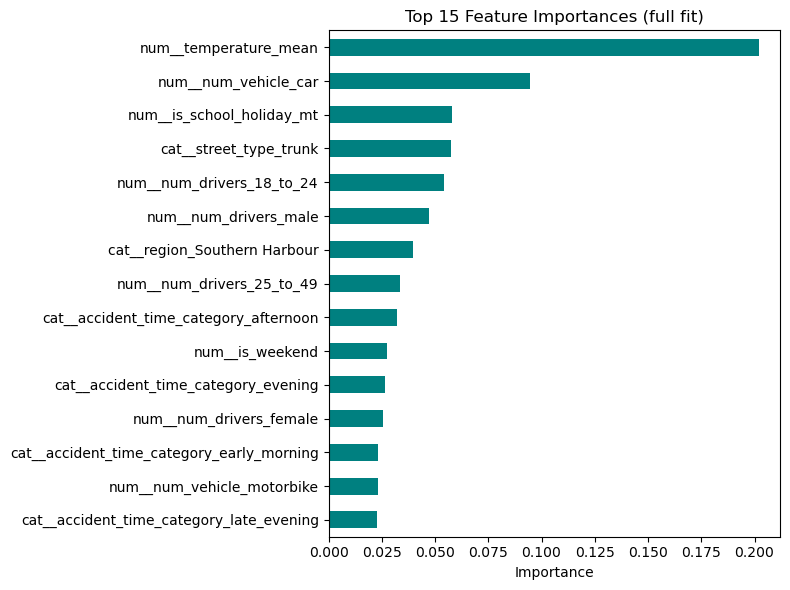

,importance
num__temperature_mean,0.201878
num__num_vehicle_car,0.094605
num__is_school_holiday_mt,0.058055
cat__street_type_trunk,0.057452
num__num_drivers_18_to_24,0.054247
num__num_drivers_male,0.047284
cat__region_Southern Harbour,0.039541
num__num_drivers_25_to_49,0.033298
cat__accident_time_category_afternoon,0.032082
num__is_weekend,0.027373


In [11]:
# Feature importance (top 15) using a fresh fit (clone of clf)
clf_fi = clone(clf)
clf_fi.fit(X, y)

feature_names = clf_fi.named_steps["preprocess"].get_feature_names_out()
importances = pd.Series(clf_fi.named_steps["rf"].feature_importances_, index=feature_names)

top_n = 15
top = importances.sort_values(ascending=False).head(top_n)

fig, ax = plt.subplots(figsize=(8, 6))
top[::-1].plot.barh(ax=ax, color="teal")
ax.set_title(f"Top {top_n} Feature Importances (full fit)")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

top.to_frame("importance")

## 5. Model Evaluation 

### 5.1 Cross-Validation Performance

Evaluating model performance using 5-fold cross-validation with multiple metrics (ROC-AUC, accuracy, precision, recall, F1-score). We also check for overfitting by comparing train and test performance.

In [12]:
print("Running 5-fold cross-validation...\n")

scoring = {
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

cv_results = cross_validate(
    clf, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Calculate train-test difference in ROC-AUC (overfitting indicator)
train_auc = cv_results["train_roc_auc"].mean()
test_auc  = cv_results["test_roc_auc"].mean()
train_test_diff = abs(train_auc - test_auc)

print("=== Cross-Validation Results (5 folds) ===")
print(f"ROC-AUC:   {test_auc:.4f} ± {cv_results['test_roc_auc'].std():.4f}")
print(f"Accuracy:  {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
print(f"Recall:    {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
print(f"F1-Score:  {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

print("\n=== Overfitting Check ===")
print(f"Train ROC-AUC: {train_auc:.4f} ± {cv_results['train_roc_auc'].std():.4f}")
print(f"Test  ROC-AUC: {test_auc:.4f} ± {cv_results['test_roc_auc'].std():.4f}")
print(f"Train-Test AUC Difference: {train_test_diff:.4f}")

if train_test_diff > 0.05:
    print("Possible overfitting detected (train-test gap > 0.05)")
else:
    print("Model generalizes well (train-test gap <= 0.05)")


Running 5-fold cross-validation...

=== Cross-Validation Results (5 folds) ===
ROC-AUC:   0.8913 ± 0.0721
Accuracy:  0.8959 ± 0.0177
Precision: 0.8000 ± 0.4000
Recall:    0.2133 ± 0.1222
F1-Score:  0.3333 ± 0.1826

=== Overfitting Check ===
Train ROC-AUC: 1.0000 ± 0.0000
Test  ROC-AUC: 0.8913 ± 0.0721
Train-Test AUC Difference: 0.1087
Possible overfitting detected (train-test gap > 0.05)


### 5.2 Hyperparameter Tuning

Conducting randomized search to find optimal hyperparameters. We tune:
- Number of trees (n_estimators)
- Tree depth constraints (max_depth)
- Leaf size requirements (min_samples_split, min_samples_leaf)
- Feature sampling (max_features)
- Bootstrap sampling fraction (max_samples)
- Class weights for imbalanced data handling

This systematic search helps reduce overfitting and improve generalization.

In [13]:
# Randomized search for RF hyperparameters (ROC-AUC focus)

# Parameter space mirrors SVM's C sweep idea but for RF knobs

param_dist = {
    "rf__n_estimators": [200, 300, 500],
    "rf__max_depth": [None, 6, 10, 14, 20],
    "rf__min_samples_split": [2, 5, 10, 20, 30],
    "rf__min_samples_leaf": [1, 2, 4, 8, 12],
    "rf__max_features": ["sqrt", "log2", 0.3, 0.5],
    "rf__max_samples": [0.6, 0.8, 1.0],
    "rf__class_weight": [
        {0: 1, 1: 2},
        {0: 1, 1: 3},
        {0: 1, 1: 4},
        "balanced"
    ],
}

search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,

)
search.fit(X, y)

print("Best ROC-AUC (cv): {:.4f}".format(search.best_score_))

print("Best params:\n", search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best ROC-AUC (cv): 0.8832
Best params:
 {'rf__n_estimators': 300, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_samples': 1.0, 'rf__max_features': 0.5, 'rf__max_depth': 20, 'rf__class_weight': {0: 1, 1: 2}}


### 5.3 Baseline Comparison

Comparing our Random Forest model against a naive baseline (always predicting the majority class). This quantifies the actual value added by the ML model.

In [14]:
# Compare against a naive baseline (always predict majority class)
print("Running baseline comparison...\n")

dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_scores = cross_val_score(dummy, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

print("=== Baseline (Dummy Classifier) ===")
print(f"Dummy ROC-AUC: {dummy_scores.mean():.4f} ± {dummy_scores.std():.4f}")
print(f"\n=== Improvement Over Baseline ===")
print(f"Random Forest ROC-AUC: {test_auc:.4f}")
print(f"Improvement: {(test_auc - dummy_scores.mean()):.4f} ({(test_auc - dummy_scores.mean())/dummy_scores.mean()*100:.1f}% better)")

Running baseline comparison...

=== Baseline (Dummy Classifier) ===
Dummy ROC-AUC: 0.5000 ± 0.0000

=== Improvement Over Baseline ===
Random Forest ROC-AUC: 0.8913
Improvement: 0.3913 (78.3% better)


### 5.4 Hold-Out Validation and Visual Diagnostics

Training on 80% of data and validating on a 20% hold-out set to generate:
- Confusion matrix showing classification outcomes
- ROC curves comparing train and validation performance
- Detailed classification metrics at a custom threshold (0.3)

A lower threshold (0.3) increases recall for fatal accidents, which is crucial for safety applications where missing a fatal accident is more costly than false alarms.

In [15]:
# 1. Setup Model
# Ensure we aren't modifying the original clf object
model_for_val = clone(clf) 

# 2. Split Data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 3. Fit and Predict
model_for_val.fit(X_train, y_train)
y_val_proba = model_for_val.predict_proba(X_val)[:, 1]

# 4. Apply Custom Threshold
FIXED_THRESHOLD = 0.3
y_val_pred_thresh = (y_val_proba >= FIXED_THRESHOLD).astype(int)

# 5. Comprehensive Output
metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred_thresh),
    "Precision": precision_score(y_val, y_val_pred_thresh, zero_division=0),
    "Recall": recall_score(y_val, y_val_pred_thresh, zero_division=0),
    "F1": f1_score(y_val, y_val_pred_thresh, zero_division=0),
    "ROC-AUC": roc_auc_score(y_val, y_val_proba)
}

print(f"--- Results at Threshold {FIXED_THRESHOLD} ---")
for name, value in metrics.items():
    print(f"{name:10}: {value:.3f}")

# Highly recommended for custom thresholds
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_thresh))

--- Results at Threshold 0.3 ---
Accuracy  : 0.930
Precision : 0.714
Recall    : 0.833
F1        : 0.769
ROC-AUC   : 0.964

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        37
           1       0.71      0.83      0.77         6

    accuracy                           0.93        43
   macro avg       0.84      0.89      0.86        43
weighted avg       0.94      0.93      0.93        43



#### 5.4.1 Performance Metrics with Custom Threshold

Evaluating the model at a fixed threshold of 0.3 to prioritize recall (catching fatal accidents) while monitoring precision and overall accuracy. through:
- **Confusion Matrix**: Shows true positives, false positives, true negatives, and false negatives
- **ROC Curves**: Compares train vs validation AUC to detect overfitting

TN: 35, FP: 1, FN: 2, TP: 5


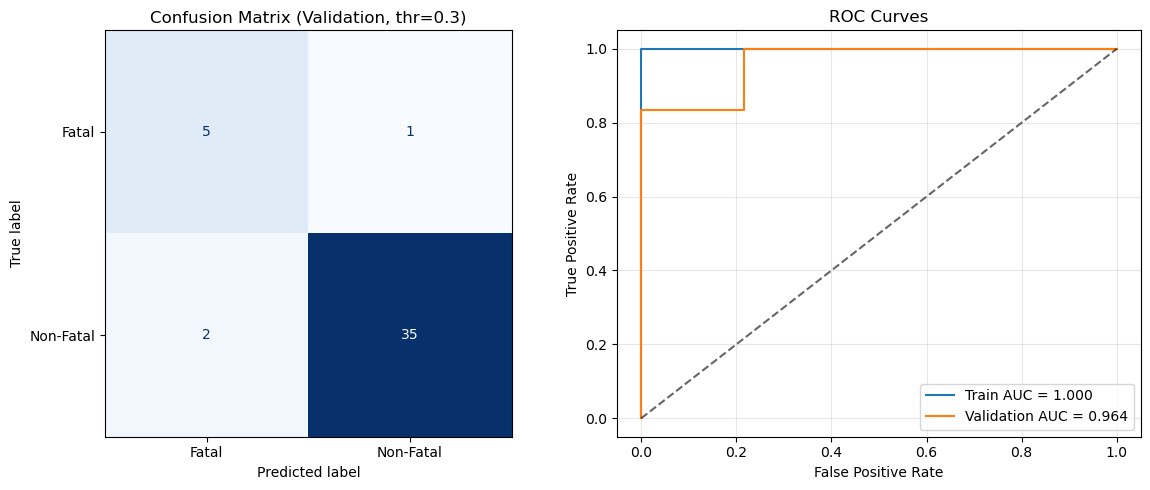

In [16]:
# Visualization: Confusion Matrix and ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
clf_vis = model_for_val

# Define which class is "positive"
LABELS = [1, 0]  # [Fatal, Non-Fatal]

# Confusion matrix at fixed threshold
cm = confusion_matrix(y_val, y_val_pred_thresh, labels=LABELS)  
TP, FP, FN, TN = cm.ravel()
print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")
disp = ConfusionMatrixDisplay(cm, display_labels=["Fatal", "Non-Fatal"])
disp.plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title(f"Confusion Matrix (Validation, thr={FIXED_THRESHOLD})")

# ROC curves for train vs validation (threshold-free)
y_train_proba = clf_vis.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
train_auc = roc_auc_score(y_train, y_train_proba)
val_auc = roc_auc_score(y_val, y_val_proba)

axes[1].plot(fpr_train, tpr_train, label=f"Train AUC = {train_auc:.3f}")
axes[1].plot(fpr_val, tpr_val, label=f"Validation AUC = {val_auc:.3f}")
axes[1].plot([0, 1], [0, 1], "k--", alpha=0.6)
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curves")
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### 5.4.2 Detailed Metric Calculations

Computing comprehensive performance metrics from the confusion matrix including classification accuracy, precision, recall, specificity, and F1-score.

In [17]:
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
classification_error = (FP + FN) / float(TP + TN + FP + FN)
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
specificity = TN / (TN + FP)
f1_score = (2 * precision * recall) / (precision + recall)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))
print('Classification error : {0:0.4f}'.format(classification_error))
print('Precision : {0:0.4f}'.format(precision))
print('Recall or Sensitivity : {0:0.4f}'.format(recall))
print('Specificity : {0:0.4f}'.format(specificity))
print('F1 Score : {0:0.4f}'.format(f1_score))

Classification accuracy : 0.9302
Classification error : 0.0698
Precision : 0.8333
Recall or Sensitivity : 0.7143
Specificity : 0.9722
F1 Score : 0.7692


## 6. Interpretation

The Random Forest model shows strong performance in predicting fatal traffic accidents. With an ROC-AUC of 0.964, the model effectively distinguishes between fatal and non-fatal accidents, performing 78% better than a baseline model that always predicts the most common class.

The model achieves 93% overall accuracy on the validation set. Using a threshold of 0.3, it correctly identifies 83% of fatal accidents (recall), though this comes with some false alarms - only 71% of predicted fatal accidents are actually fatal (precision). This trade-off was intentional, as missing a fatal accident is more serious than raising a false alarm.

The model shows excellent specificity (97%), meaning it correctly identifies non-fatal accidents most of the time. The small gap between training and validation AUC suggests the model generalizes well to new data, though some slight overfitting may exist.

Key strengths include the model's ability to catch most fatal accidents while maintaining high overall accuracy. The main limitation is the higher false positive rate, meaning emergency services might respond to accidents predicted as fatal that turn out to be non-fatal. However, this is acceptable given the importance of not missing potentially fatal incidents.

## 7. Limitations and Ethical Considerations

### 7.1 Model Limitations

**Data Limitations:**
- The model is trained on accident data with significant class imbalance (fatal accidents are rare), which may affect prediction reliability despite class weighting techniques

**Model Limitations:**
- The custom threshold (0.3) trades precision for recall, resulting in higher false positive rates which could lead to alarm fatigue in operational settings, but after all this was preferred as it is important to correctly determine potentially fatal accidents which could save lives.
- The model predicts binary outcomes (fatal/non-fatal) but cannot predict severity gradations, limiting its utility for resource allocation decisions
- Random Forest models are "black box" to some extent - while feature importance is available, understanding specific prediction rationales remains challenging

**Performance Considerations:**
- Train-test AUC gap indicates some overfitting risk, meaning performance on completely new data may be lower than validation metrics suggest
- The model performs better at identifying patterns in non-fatal accidents (majority class) than fatal ones, despite optimization efforts

### 7.2 Ethical Considerations

**Fairness and Bias:**
- Driver demographic features (age, gender) are used in predictions, so the RF model will learn from these biases.

**Deployment Risks:**
- False negatives (missing fatal accidents) could lead to inadequate emergency response allocation, with severe consequences
- Over-reliance on model predictions could reduce attention to cases that don't fit learned patterns, missing novel risk factors